In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector

# Loading the Stores dataset
stores = pd.read_csv("D:/Stores.csv", encoding='latin1')
print(stores.head())

   StoreKey    Country                         State  Square Meters  Open Date
0         1  Australia  Australian Capital Territory          595.0   1/1/2008
1         2  Australia            Northern Territory          665.0  1/12/2008
2         3  Australia               South Australia         2000.0   1/7/2012
3         4  Australia                      Tasmania         2000.0   1/1/2010
4         5  Australia                      Victoria         2000.0  12/9/2015


In [14]:
stores

,StoreKey,Country,State,Square Meters,Open Date
0,1,Australia,Australian Capital Territory,595.0,1/1/2008
1,2,Australia,Northern Territory,665.0,1/12/2008
2,3,Australia,South Australia,2000.0,1/7/2012
3,4,Australia,Tasmania,2000.0,1/1/2010
4,5,Australia,Victoria,2000.0,12/9/2015
...,...,...,...,...,...
62,63,United States,Utah,2000.0,3/6/2008
63,64,United States,Washington DC,1330.0,1/1/2010
64,65,United States,West Virginia,1785.0,1/1/2012
65,66,United States,Wyoming,840.0,1/1/2014


In [16]:
# Data Information
print("\nStores Data Info:")
stores.info()


Stores Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   StoreKey       67 non-null     int64  
 1   Country        67 non-null     object 
 2   State          67 non-null     object 
 3   Square Meters  66 non-null     float64
 4   Open Date      67 non-null     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.7+ KB


In [17]:
# Data Cleaning
# 1. Check for missing values
print("Missing values in Stores:\n", stores.isnull().sum())

# 2. Handle missing values in 'Square Meters'
# Option 1: Fill missing Square Meters with the mean
mean_square_meters = stores['Square Meters'].mean()
stores['Square Meters'] = stores['Square Meters'].fillna(mean_square_meters)

# 3. Remove duplicate values
stores = stores.drop_duplicates(subset='StoreKey')

# Check for missing values again after handling
print("Missing values in Stores after handling:\n", stores.isnull().sum())


Missing values in Stores:
 StoreKey         0
Country          0
State            0
Square Meters    1
Open Date        0
dtype: int64
Missing values in Stores after handling:
 StoreKey         0
Country          0
State            0
Square Meters    0
Open Date        0
dtype: int64



Descriptive Statistics:
         StoreKey  Square Meters
count  67.000000      67.000000
mean   33.000000    1402.196970
std    19.485037     572.020693
min     0.000000     245.000000
25%    16.500000    1112.500000
50%    33.000000    1365.000000
75%    49.500000    2000.000000
max    66.000000    2105.000000


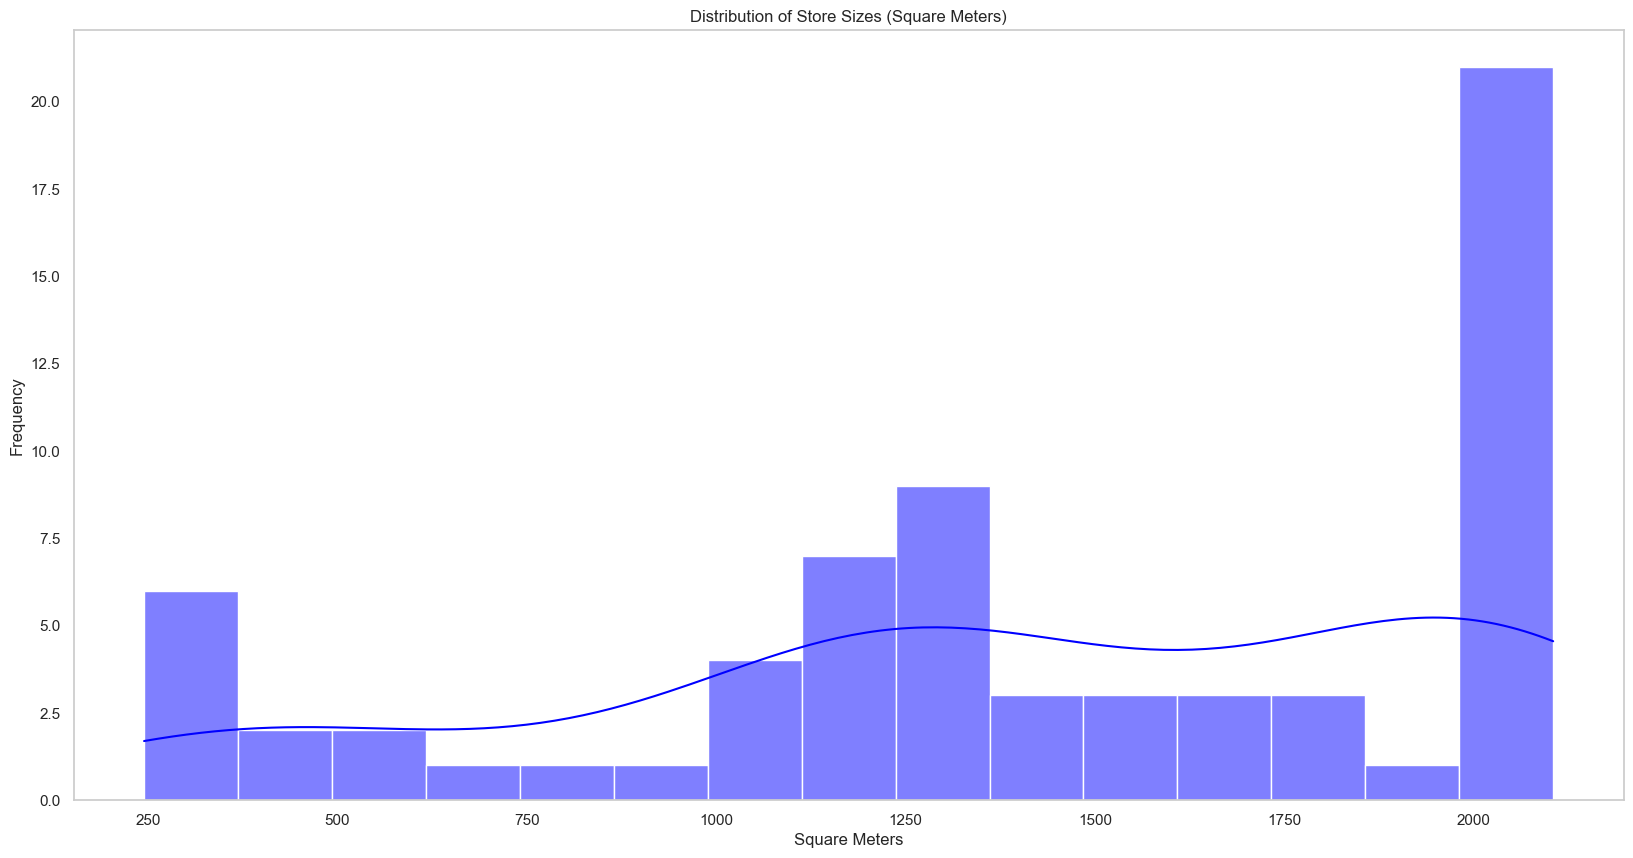

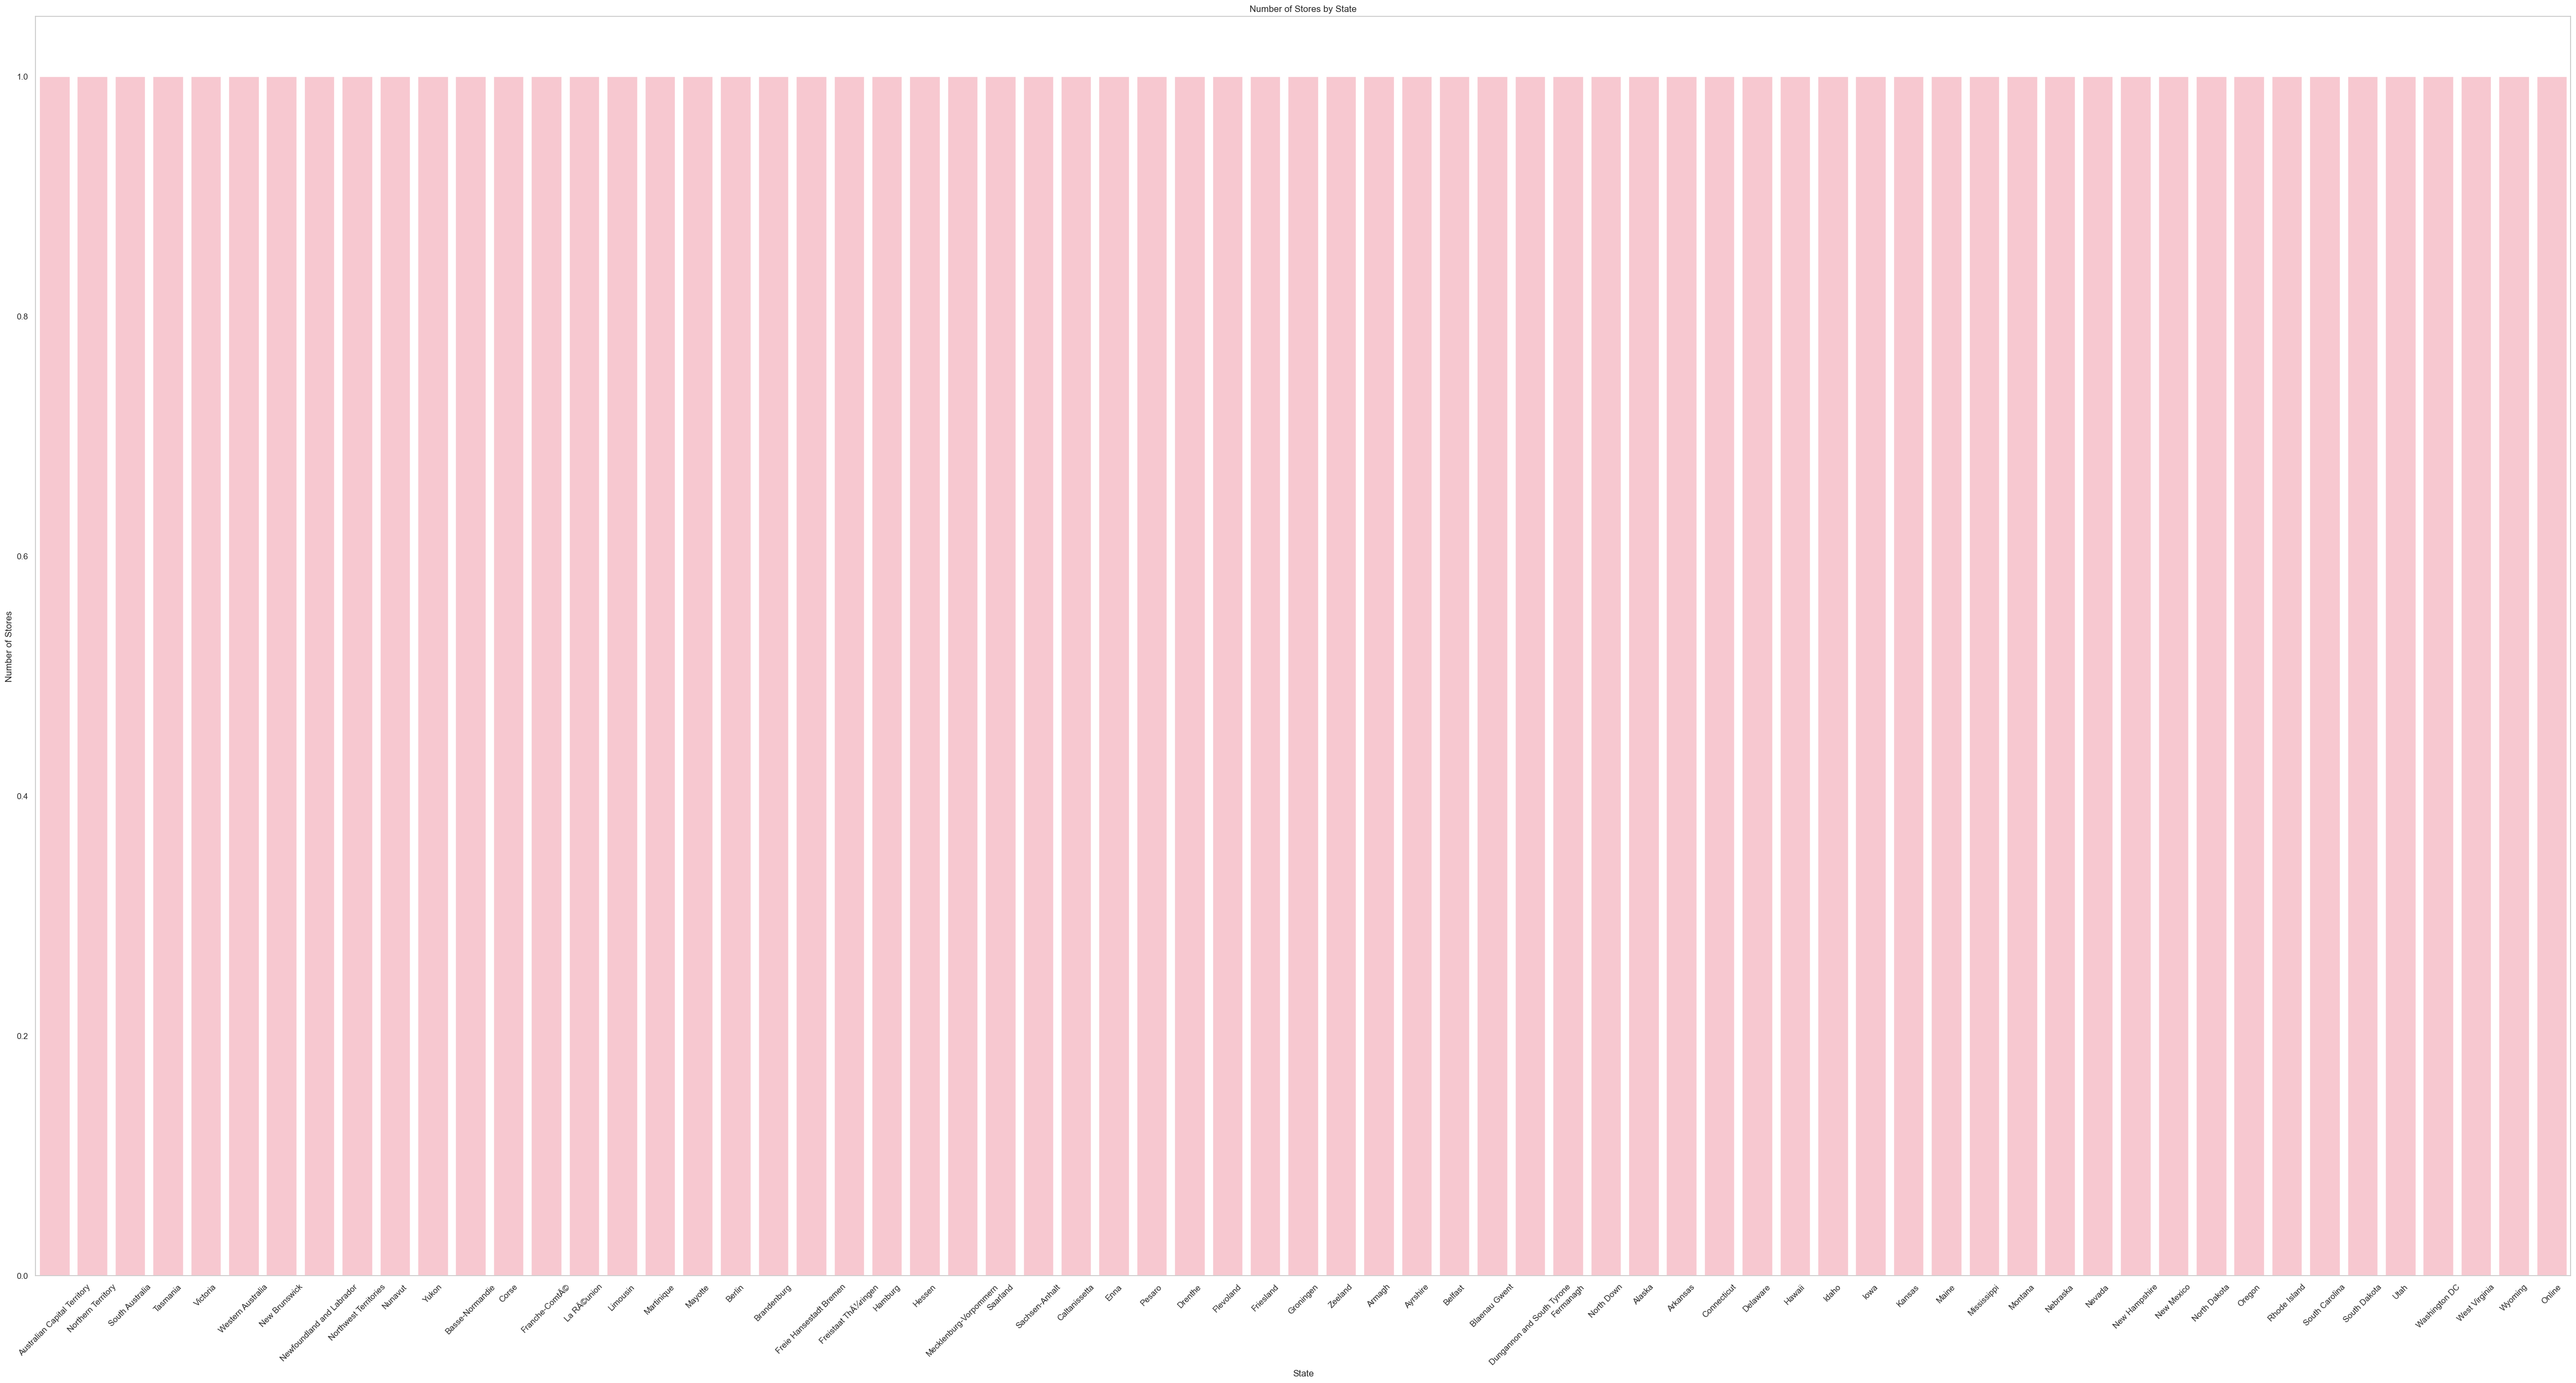

In [18]:
#EDA
#descriptive statistics
descriptive_stats = stores.describe()
print("\nDescriptive Statistics:\n", descriptive_stats)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plotting the distribution of store sizes
plt.figure(figsize=(20, 10))
sns.histplot(stores['Square Meters'], bins=15, kde=True, color='blue')
plt.title('Distribution of Store Sizes (Square Meters)')
plt.xlabel('Square Meters')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Counting the number of stores by state
state_counts = stores['State'].value_counts()

# Plotting the number of stores by state
plt.figure(figsize=(60, 30))
sns.barplot(x=state_counts.index, y=state_counts.values, color='pink')
plt.title('Number of Stores by State')
plt.xlabel('State')
plt.ylabel('Number of Stores')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [19]:
# Connecting to MySQL database
db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="3008",
    database="global_electronics"
)

cursor = db_connection.cursor()

# Create table if it doesn't exist
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Stores (
        StoreKey INT PRIMARY KEY,
        Country VARCHAR(255),
        State VARCHAR(255),
        SquareMeters INT,
        OpenDate DATE
    );
''')

# Convert each row of the DataFrame to a tuple for SQL insertion
rows_to_insert = [tuple(row) for row in stores.values]

# Insert data in batches
batch_size = 500  
for start in range(0, len(rows_to_insert), batch_size):
    batch = rows_to_insert[start:start + batch_size]
    
    try:
        cursor.executemany('''
            INSERT IGNORE INTO Stores (StoreKey, Country, State, SquareMeters, OpenDate)
            VALUES (%s, %s, %s, %s, %s)
        ''', batch)
        db_connection.commit()
    except mysql.connector.Error as err:
        print(f"Error in batch {start // batch_size + 1}: {err}")
        db_connection.rollback()

# Confirm successful insertions by counting rows in the table
cursor.execute("SELECT COUNT(*) FROM Stores")
row_count = cursor.fetchone()[0]
print(f"Total stores inserted: {row_count}")

# Close the cursor and database connection
cursor.close()
db_connection.close()


Total stores inserted: 67
